
# Group Assignment 1: Motor Insurance Claims Analysis  
**Module:** ACFI827 – Introduction to Programming (Python), MSc FinTech  
**University of Liverpool – 2025**

**Authors:** *[Your Full Name(s)]*  
**Student ID(s):** *[e.g., 202512345]*  
**Date:** *[e.g., 09‑Nov‑2025]*

---

## Notebook Purpose

This notebook converts the original single `.py` file into a sequence of **small, clearly explained steps**.  
For each step you will find:
- a **pre‑comment** (what/why we do it),
- a **code cell** (how we do it),
- a **post‑comment** (what we learned / what to check next).

We keep the original structure:
- **Task A – Data Exploration & Preparation**
- **Task B – Injury & Rehabilitation Analysis**
- **Task C – Total Claim Amount Estimation** (Rule‑based baseline + ML calibration)

> **Instructions**: Place `motor_insurance_recovery.csv` in the same folder as this notebook before running.



## Environment Check & Imports (Before)
We import libraries used across the project.  
If you run this on a clean environment, ensure `pandas`, `numpy`, `matplotlib`, `seaborn`, and `scikit-learn` are installed.


In [1]:

# Core imports
import os, re
import numpy as np
import pandas as pd

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# ML utilities
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

print('Libraries imported successfully.')

Libraries imported successfully.


**After:** The environment is ready.


---
# Task A – Data Exploration

### STEP A1 – Load the dataset (Before)
Load the raw dataset and inspect shape, dtypes, duplicates, and missing values.


In [2]:

FILE_PATH = 'motor_insurance_recovery.csv'
if not os.path.exists(FILE_PATH):
    raise FileNotFoundError(f"Dataset not found at {FILE_PATH}. "
                            "Please place 'motor_insurance_recovery.csv' next to this notebook.")

df = pd.read_csv(FILE_PATH)
print('TASK A – Data Exploration\n')
print('Rows and Columns:', df.shape)
print('Duplicate rows:', df.duplicated().sum())

print('\nData types:\n', df.dtypes)
print('\nMissing values per column:\n', df.isna().sum().sort_values(ascending=False))

TASK A – Data Exploration

Rows and Columns: (1000, 36)
Duplicate rows: 0

Data types:
 client_id                                  int64
claim_value_category                       int64
injury_duration_days                       int64
hospital_visit_required                    int64
medical_care_sought                        int64
hospital_admission_required                int64
currently_unemployed_due_to_injury         int64
work_absence_duration_days                 int64
work_absence_required                      int64
rehabilitation_recommended                 int64
rehabilitation_completed                   int64
minor_claimant_at_initial_assessment       int64
defendant_title_code                       int64
liability_admission_status                object
liability_type                            object
claimant_age_at_incident                   int64
liability_denial_reasons                  object
claim_rejection_code                      object
claims_management_exit_notes  

**After:** Baseline data quality established.


### STEP A2 – Numeric Summary (Before)
Summarise numeric columns to understand ranges and negatives.


In [3]:

numeric_cols = df.select_dtypes(include=[np.number]).columns
num_summary = df[numeric_cols].describe().T
num_summary['negatives_count'] = (df[numeric_cols] < 0).sum()
print('\nNumeric summary (first few rows):')
print(num_summary.head())


Numeric summary (first few rows):
                          count     mean         std  min     25%    50%  \
client_id                1000.0  500.500  288.819436  1.0  250.75  500.5   
claim_value_category     1000.0    1.554    0.940196  1.0    1.00    1.0   
injury_duration_days     1000.0   40.673   26.987597  0.0   19.75   40.0   
hospital_visit_required  1000.0    0.594    0.491330  0.0    0.00    1.0   
medical_care_sought      1000.0    0.917    0.276020  0.0    1.00    1.0   

                            75%     max  negatives_count  
client_id                750.25  1000.0                0  
claim_value_category       2.00     5.0                0  
injury_duration_days      60.00   150.0                0  
hospital_visit_required    1.00     1.0                0  
medical_care_sought        1.00     1.0                0  


**After:** Check for suspicious ranges.


### STEP A3 – Binary/Category Distributions (Before)
Check distributions for key binary and categorical fields.


In [4]:

binary_flags = [
    "hospital_visit_required", "medical_care_sought", "hospital_admission_required",
    "currently_unemployed_due_to_injury", "work_absence_required",
    "rehabilitation_recommended", "rehabilitation_completed",
    "minor_claimant_at_initial_assessment"
]
print('\nBinary flag distributions:')
for b in binary_flags:
    if b in df.columns:
        vals = df[b].value_counts(normalize=True).mul(100).round(1)
        print(f"{b}: {vals.to_dict()}")

for col in ["car_damage_severity", "emergency_services_attended"]:
    if col in df.columns:
        print(f"\nCategory counts for {col}:")
        print(df[col].value_counts(normalize=True).mul(100).round(1))


Binary flag distributions:
hospital_visit_required: {1: 59.4, 0: 40.6}
medical_care_sought: {1: 91.7, 0: 8.3}
hospital_admission_required: {0: 89.6, 1: 10.4}
currently_unemployed_due_to_injury: {0: 60.5, 1: 39.5}
work_absence_required: {1: 67.1, 0: 32.9}
rehabilitation_recommended: {1: 81.5, 0: 18.5}
rehabilitation_completed: {1: 59.1, 0: 40.9}
minor_claimant_at_initial_assessment: {0: 96.5, 1: 3.5}

Category counts for car_damage_severity:
car_damage_severity
moderate      31.1
minor         30.1
severe        29.0
none           5.3
total_loss     4.5
Name: proportion, dtype: float64

Category counts for emergency_services_attended:
emergency_services_attended
ambulance_and_police    41.2
ambulance               24.4
police                  20.0
none                    14.4
Name: proportion, dtype: float64


**After:** Category balance confirmed.


### STEP A4 – Focused Summary of Important Numerics (Before)
Inspect key numerical variables likely to influence total claim amounts.


In [5]:

focus_cols = [
    "injury_duration_days", "work_absence_duration_days", "medical_attention_delay_days",
    "claimant_age_at_incident", "insurance_deductible_amount", "total_claim_amount",
    "medical_treatment_costs", "general_damages"
]
print('\nFocus columns summary:\n')
print(df[focus_cols].describe().T)


Focus columns summary:

                               count         mean          std      min  \
injury_duration_days          1000.0     40.67300    26.987597     0.00   
work_absence_duration_days    1000.0     16.57600    13.115649     0.00   
medical_attention_delay_days  1000.0      8.41500    19.886232     0.00   
claimant_age_at_incident      1000.0     49.58600    12.085225    18.00   
insurance_deductible_amount   1000.0    106.65000    95.012130     0.00   
total_claim_amount            1000.0  21171.38907  8795.517385  1792.15   
medical_treatment_costs       1000.0    572.19820   653.537592     0.00   
general_damages               1000.0  19871.80931  8094.735036  1528.17   

                                    25%        50%         75%       max  
injury_duration_days             19.750     40.000     60.0000    150.00  
work_absence_duration_days        5.000     16.000     26.0000     62.00  
medical_attention_delay_days      0.000      0.000      5.0000    138.00  

**After:** Ranges look reasonable.


---
## Task A – Data Preparation (Cleaning & Feature Engineering)

### STEP A5 – Drop sparse/administrative text fields (Before)
Remove operational notes and sparse text columns with low predictive value.


In [6]:

df_clean = df.copy()

drop_cols = [
    "liability_denial_reasons", "claim_rejection_code",
    "claims_management_exit_notes", "claims_resolution_exit_notes",
    "claims_resolution_closure_code", "defendant_title_code",
    "liability_admission_status", "liability_type",
    "client_id"
]
df_clean = df_clean.drop(columns=[c for c in drop_cols if c in df_clean.columns])
print('Dropped (if present):', [c for c in drop_cols if c not in df_clean.columns])

Dropped (if present): ['liability_denial_reasons', 'claim_rejection_code', 'claims_management_exit_notes', 'claims_resolution_exit_notes', 'claims_resolution_closure_code', 'defendant_title_code', 'liability_admission_status', 'liability_type', 'client_id']


**After:** Non-predictive text removed.


### STEP A6 – Fix negatives & clip outliers (Before)
Ensure non-negative for durations/costs and clip outliers at 1st/99th percentiles.


In [7]:

nonneg_cols = [
    "injury_duration_days", "work_absence_duration_days", "medical_attention_delay_days",
    "rental_vehicle_expense", "home_care_services_cost",
    "employment_disadvantage_compensation", "career_satisfaction_loss_compensation",
    "asset_utility_loss_compensation", "medical_treatment_costs",
    "general_damages", "insurance_deductible_amount", "total_claim_amount"
]
for c in nonneg_cols:
    if c in df_clean.columns:
        if (df_clean[c] < 0).sum() > 0:
            df_clean.loc[df_clean[c] < 0, c] = 0

def clip_by_quantiles(s, low=0.01, high=0.99):
    lo, hi = s.quantile([low, high])
    return s.clip(lo, hi)

clip_cols = [
    "injury_duration_days", "work_absence_duration_days", "medical_attention_delay_days",
    "medical_treatment_costs", "general_damages", "total_claim_amount"
]
for c in clip_cols:
    if c in df_clean.columns:
        df_clean[c] = clip_by_quantiles(df_clean[c])

**After:** Values are robust for modelling.


### STEP A7 – Encode categorical & multi‑label fields (Before)
- Ordinal map for `car_damage_severity`.  
- One‑hot for `emergency_services_attended`.  
- Parse multi‑value strings for injuries/rehab into binary flags and counts.


In [8]:

severity_map = {"none":0, "minor":1, "moderate":2, "severe":3, "total_loss":4}
df_clean['car_damage_severity_ord'] = df_clean['car_damage_severity'].map(severity_map)

df_clean = pd.get_dummies(df_clean, columns=['emergency_services_attended'], prefix='esa', dtype=int)

def parse_set_string(s):
    if pd.isna(s):
        return []
    items = re.sub(r"^\{|\}$", "", str(s)).split(",")
    items = [re.sub(r"[\'\"\s]", "", it) for it in items if it.strip() != ""]
    return [it for it in items if it]

inj_multi = df_clean['injury_type_classifications'].apply(parse_set_string)
rehab_multi = df_clean['rehabilitation_program_types'].apply(parse_set_string)

from collections import Counter
def top_labels(series_lists, topn=15):
    cnt = Counter(x for lst in series_lists for x in lst)
    return [w for w, _ in cnt.most_common(topn)]

top_inj = top_labels(inj_multi, topn=15)
top_rehab = top_labels(rehab_multi, topn=10)

for lab in top_inj:
    df_clean[f"inj_{lab}"] = inj_multi.apply(lambda xs: int(lab in xs))
for lab in top_rehab:
    df_clean[f"rehab_{lab}"] = rehab_multi.apply(lambda xs: int(lab in xs))

df_clean['injury_types_count'] = inj_multi.apply(len)
df_clean['rehab_types_count']  = rehab_multi.apply(len)

if 'claimant_current_age_years' in df_clean.columns:
    df_clean = df_clean.drop(columns=['claimant_current_age_years'])

**After:** Feature-ready dataset prepared.


### STEP A8 – Feature Preview & Save Clean File (Before)
Preview features and save the cleaned dataset for later tasks.


In [9]:

feature_cols_preview = [
    'injury_duration_days','work_absence_duration_days','medical_attention_delay_days',
    'claimant_age_at_incident','insurance_deductible_amount','medical_treatment_costs',
    'general_damages','car_damage_severity_ord',
    'hospital_visit_required','medical_care_sought','hospital_admission_required',
    'currently_unemployed_due_to_injury','work_absence_required',
    'rehabilitation_recommended','rehabilitation_completed',
    'injury_types_count','rehab_types_count'
] + [c for c in df_clean.columns if c.startswith('esa_')]   + [c for c in df_clean.columns if c.startswith('inj_')]   + [c for c in df_clean.columns if c.startswith('rehab_')]

feature_cols_preview = [c for c in feature_cols_preview if c in df_clean.columns]

print('Feature columns preview (first 25):')
print(feature_cols_preview[:25])

CLEAN_PATH = 'motor_insurance_recovery_clean.csv'
df_clean.to_csv(CLEAN_PATH, index=False)
print(f"Saved: {CLEAN_PATH}")
print("Task A – Data Preparation: DONE")

Feature columns preview (first 25):
['injury_duration_days', 'work_absence_duration_days', 'medical_attention_delay_days', 'claimant_age_at_incident', 'insurance_deductible_amount', 'medical_treatment_costs', 'general_damages', 'car_damage_severity_ord', 'hospital_visit_required', 'medical_care_sought', 'hospital_admission_required', 'currently_unemployed_due_to_injury', 'work_absence_required', 'rehabilitation_recommended', 'rehabilitation_completed', 'injury_types_count', 'rehab_types_count', 'esa_ambulance', 'esa_ambulance_and_police', 'esa_none', 'esa_police', 'inj_Whiplash', 'inj_Spine/BackInjury', 'inj_LimbInjury', 'inj_SoftTissueInjury']
Saved: motor_insurance_recovery_clean.csv
Task A – Data Preparation: DONE


**After:** Clean file persisted.


---
# Task B – Injury & Rehabilitation Analysis

### STEP B1 – Load clean data & frequencies (Before)
Compute frequency of injury/rehab indicators.


In [10]:

dfb = pd.read_csv('motor_insurance_recovery_clean.csv')
inj_cols = [c for c in dfb.columns if c.startswith('inj_')]
reh_cols = [c for c in dfb.columns if c.startswith('rehab_')]

inj_freq = dfb[inj_cols].sum().sort_values(ascending=False)
reh_freq = dfb[reh_cols].sum().sort_values(ascending=False)

print('Top 10 Injury Types:')
print(inj_freq.head(10))
print('\nTop 10 Rehabilitation Programs:')
print(reh_freq.head(10))

Top 10 Injury Types:
inj_Whiplash               495
inj_Spine/BackInjury       141
inj_LimbInjury             137
inj_SoftTissueInjury       133
inj_InternalInjury         131
inj_BoneInjury             128
inj_BurnsandScalds         124
inj_Miscellaneous          113
inj_PsychologicalIssues    111
inj_DentalInjury           110
dtype: int64

Top 10 Rehabilitation Programs:
rehab_types_count            1314
rehab_Unknown                 297
rehab_physiotherapy           155
rehab_painrelief              133
rehab_exercises               119
rehab_surgery                 118
rehab_massage                 107
rehab_hot/coldtreatment        90
rehab_medicalconsultation      78
rehab_splint                   64
dtype: int64


**After:** Prevalence understood.


### STEP B2 – Visualise top injury & rehab categories (Before)


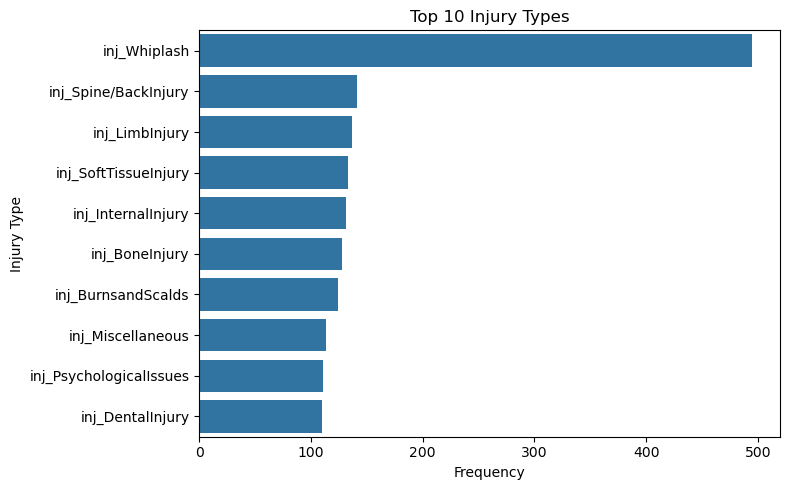

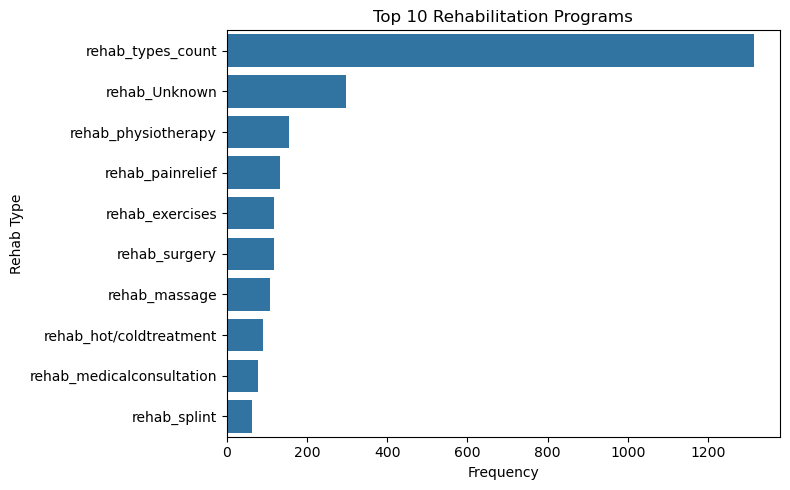

In [11]:

plt.figure(figsize=(8,5))
sns.barplot(x=inj_freq.head(10).values, y=inj_freq.head(10).index)
plt.title('Top 10 Injury Types')
plt.xlabel('Frequency'); plt.ylabel('Injury Type')
plt.tight_layout(); plt.show()

plt.figure(figsize=(8,5))
sns.barplot(x=reh_freq.head(10).values, y=reh_freq.head(10).index)
plt.title('Top 10 Rehabilitation Programs')
plt.xlabel('Frequency'); plt.ylabel('Rehab Type')
plt.tight_layout(); plt.show()

**After:** Visual confirmation complete.


### STEP B3 – Boxplot: Rehab completion vs injury duration (Before)


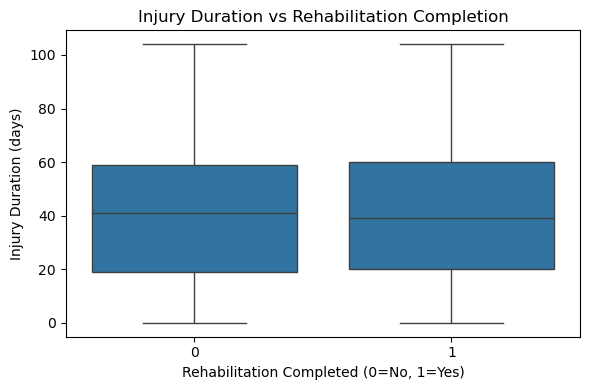

In [12]:

plt.figure(figsize=(6,4))
sns.boxplot(data=dfb, x='rehabilitation_completed', y='injury_duration_days')
plt.title('Injury Duration vs Rehabilitation Completion')
plt.xlabel('Rehabilitation Completed (0=No, 1=Yes)')
plt.ylabel('Injury Duration (days)')
plt.tight_layout(); plt.show()

**After:** Distributional differences observed.


### STEP B4 – Compute ISS_ins (Before)
Create the insurance‑oriented severity score.


In [13]:

def compute_iss_ins(row):
    dur_score = min(row['injury_duration_days'] / 15, 5)  # cap at 5
    hosp_score = 2 if row['hospital_admission_required'] == 1 else (1 if row['hospital_visit_required'] == 1 else 0)
    rehab_score = 1 if row['rehabilitation_completed'] == 1 else 1.5
    inj_count_score = min(row['injury_types_count'], 5)
    car_sev_score = row['car_damage_severity_ord'] * 0.5
    total = dur_score + hosp_score + rehab_score + inj_count_score + car_sev_score
    return round(min(total, 10), 2)

dfb['ISS_ins'] = dfb.apply(compute_iss_ins, axis=1)
dfb[['ISS_ins','injury_duration_days','car_damage_severity_ord','injury_types_count']].head()

,ISS_ins,injury_duration_days,car_damage_severity_ord,injury_types_count
0,7.67,55,2,2
1,6.10,54,1,1
2,10.00,61,1,4
3,10.00,83,3,2
4,9.07,46,2,3


**After:** `ISS_ins` computed.


### STEP B5 – Correlation & Scatter (Before)
Inspect correlations and the core relationship with total claim.


Correlation matrix:
                           ISS_ins  injury_duration_days  \
ISS_ins                  1.000000              0.834546   
injury_duration_days     0.834546              1.000000   
medical_treatment_costs  0.279089              0.291999   
general_damages          0.830273              0.871653   
total_claim_amount       0.820340              0.856553   

                         medical_treatment_costs  general_damages  \
ISS_ins                                 0.279089         0.830273   
injury_duration_days                    0.291999         0.871653   
medical_treatment_costs                 1.000000         0.347517   
general_damages                         0.347517         1.000000   
total_claim_amount                      0.405700         0.984872   

                         total_claim_amount  
ISS_ins                            0.820340  
injury_duration_days               0.856553  
medical_treatment_costs            0.405700  
general_damages          

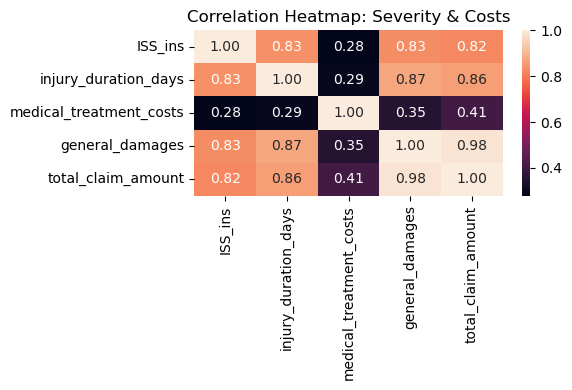

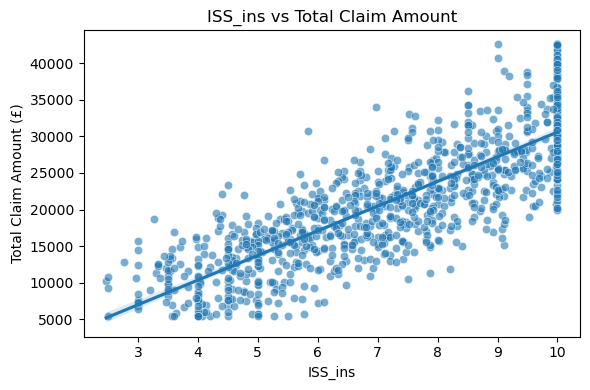

In [14]:

corr = dfb[['ISS_ins','injury_duration_days','medical_treatment_costs','general_damages','total_claim_amount']].corr()
print('Correlation matrix:\n', corr)

plt.figure(figsize=(6,4))
sns.heatmap(corr, annot=True, fmt='.2f')
plt.title('Correlation Heatmap: Severity & Costs')
plt.tight_layout(); plt.show()

plt.figure(figsize=(6,4))
sns.scatterplot(x='ISS_ins', y='total_claim_amount', data=dfb, alpha=0.6)
sns.regplot(x='ISS_ins', y='total_claim_amount', data=dfb, scatter=False)
plt.title('ISS_ins vs Total Claim Amount')
plt.xlabel('ISS_ins'); plt.ylabel('Total Claim Amount (£)')
plt.tight_layout(); plt.show()

**After:** Associations validated.


---
# Task C – Total Claim Estimation

## Step C1 – Rule‑Based Estimator (Before)
A transparent baseline that mimics an insurer’s expert calculation.


In [15]:

dfc = pd.read_csv('motor_insurance_recovery_clean.csv')
if 'ISS_ins' not in dfc.columns:
    dfc['ISS_ins'] = dfc.apply(compute_iss_ins, axis=1)

def estimate_claim(row):
    GD = 1000 * row['ISS_ins'] + 150 * row['injury_duration_days']
    if row['hospital_admission_required'] == 1:
        GD *= 1.15
    if row['rehabilitation_completed'] == 1:
        GD *= 0.95

    SD = row['medical_treatment_costs'] + 40 * row['work_absence_duration_days'] + 0.5 * row['insurance_deductible_amount']
    Adj = 200 * row['car_damage_severity_ord'] + 250 * row['injury_types_count']
    Deductible = row['insurance_deductible_amount']
    return GD + SD + Adj - Deductible

dfc['predicted_claim_rule'] = dfc.apply(estimate_claim, axis=1)

y_true = dfc['total_claim_amount']
y_pred = dfc['predicted_claim_rule']

mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
r2  = r2_score(y_true, y_pred)

print('Rule‑Based Model Performance:')
print(f"MAE:  £{mae:,.2f}")
print(f"RMSE: £{rmse:,.2f}")
print(f"R²:   {r2:.3f}")

Rule‑Based Model Performance:
MAE:  £6,051.20
RMSE: £7,085.55
R²:   0.300


**After:** Baseline established.


## Step C2 – Visualise Rule‑Based Accuracy (Before)


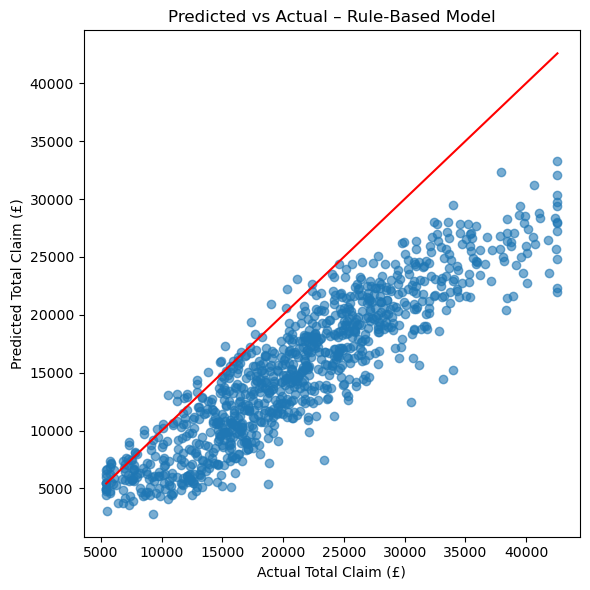

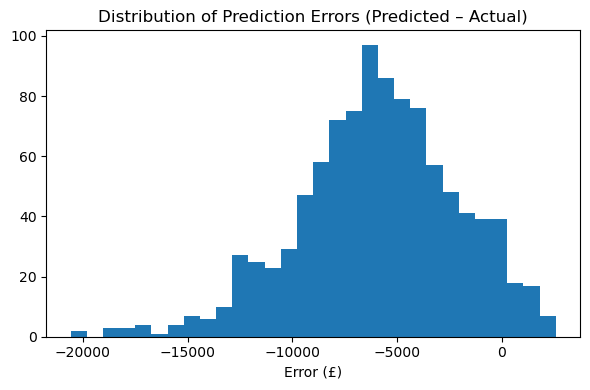

In [16]:

plt.figure(figsize=(6,6))
plt.scatter(y_true, y_pred, alpha=0.6)
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r-')
plt.xlabel('Actual Total Claim (£)'); plt.ylabel('Predicted Total Claim (£)')
plt.title('Predicted vs Actual – Rule‑Based Model')
plt.tight_layout(); plt.show()

dfc['error'] = y_pred - y_true
plt.figure(figsize=(6,4))
plt.hist(dfc['error'], bins=30)
plt.title('Distribution of Prediction Errors (Predicted – Actual)')
plt.xlabel('Error (£)')
plt.tight_layout(); plt.show()

**After:** Residual structure motivates ML calibration.


## Step C3 – ML Calibration (Before)
Two models:
- **Model A** with `general_damages` (upper bound / diagnostic).
- **Model B** without `general_damages` (realistic predictive, no leakage).



[Model A (with General Damages)] FEATURES = 11
 LinearReg  -> MAE £679 | RMSE £924 | R² 0.987
 GradientGB -> MAE £775 | RMSE £1,113 | R² 0.981
 5-Fold CV (Linear) R²: mean 0.975 ± 0.012


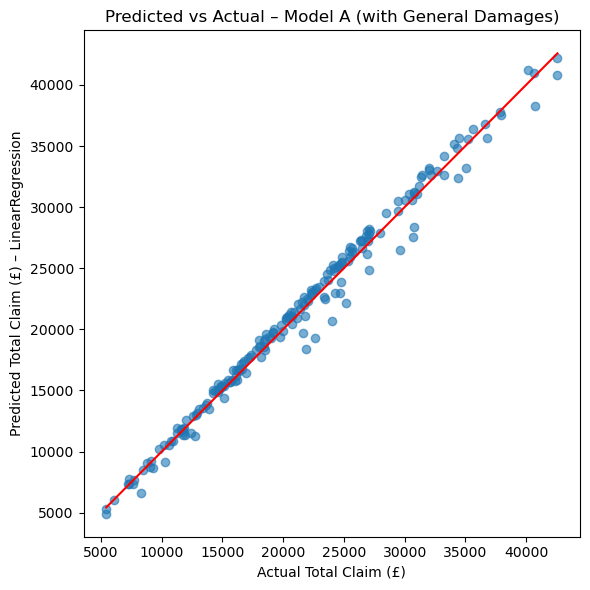


[Model B (no General Damages)] FEATURES = 10
 LinearReg  -> MAE £1,795 | RMSE £2,142 | R² 0.931
 GradientGB -> MAE £1,975 | RMSE £2,383 | R² 0.915
 5-Fold CV (Linear) R²: mean 0.922 ± 0.010


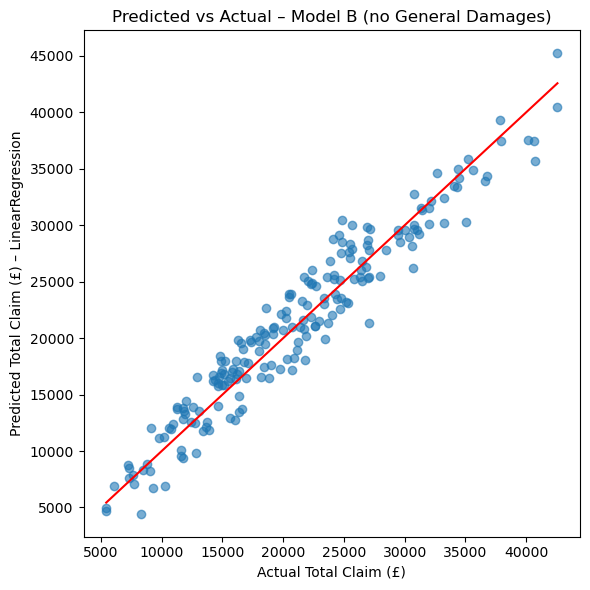

In [17]:

need_cols = [
    "total_claim_amount", "predicted_claim_rule", "ISS_ins",
    "injury_duration_days", "work_absence_duration_days",
    "medical_treatment_costs", "insurance_deductible_amount",
    "car_damage_severity_ord", "rehabilitation_completed",
    "hospital_admission_required", "injury_types_count",
    "general_damages"
]
missing = [c for c in need_cols if c not in dfc.columns]
if missing:
    raise ValueError(f"Missing required columns for ML step: {missing}")

features_A = [
    "predicted_claim_rule","general_damages","medical_treatment_costs",
    "ISS_ins","injury_duration_days","work_absence_duration_days",
    "car_damage_severity_ord","rehabilitation_completed",
    "hospital_admission_required","insurance_deductible_amount",
    "injury_types_count"
]

features_B = [
    "predicted_claim_rule","medical_treatment_costs",
    "ISS_ins","injury_duration_days","work_absence_duration_days",
    "car_damage_severity_ord","rehabilitation_completed",
    "hospital_admission_required","insurance_deductible_amount",
    "injury_types_count"
]

y = dfc["total_claim_amount"].values

def eval_and_report(X, label):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    lr  = LinearRegression().fit(X_train, y_train)
    gbr = GradientBoostingRegressor(random_state=42, n_estimators=300, max_depth=3, learning_rate=0.05).fit(X_train, y_train)
    pred_lr  = lr.predict(X_test)
    pred_gbr = gbr.predict(X_test)

    def metrics(y_true, y_pred):
        mae = mean_absolute_error(y_true, y_pred)
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        r2  = r2_score(y_true, y_pred)
        return mae, rmse, r2

    mae_lr, rmse_lr, r2_lr = metrics(y_test, pred_lr)
    mae_gb, rmse_gb, r2_gb = metrics(y_test, pred_gbr)

    print(f"\n[{label}] FEATURES = {X.shape[1]}")
    print(f" LinearReg  -> MAE £{mae_lr:,.0f} | RMSE £{rmse_lr:,.0f} | R² {r2_lr:.3f}")
    print(f" GradientGB -> MAE £{mae_gb:,.0f} | RMSE £{rmse_gb:,.0f} | R² {r2_gb:.3f}")

    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    cv_r2 = cross_val_score(lr, X, y, cv=kf, scoring='r2')
    print(f" 5-Fold CV (Linear) R²: mean {cv_r2.mean():.3f} ± {cv_r2.std():.3f}")

    best_pred = pred_gbr if r2_gb >= r2_lr else pred_lr
    best_name = "GradientBoosting" if r2_gb >= r2_lr else "LinearRegression"
    plt.figure(figsize=(6,6))
    plt.scatter(y_test, best_pred, alpha=0.6)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r-')
    plt.xlabel('Actual Total Claim (£)'); plt.ylabel(f'Predicted Total Claim (£) – {best_name}')
    plt.title(f'Predicted vs Actual – {label}')
    plt.tight_layout(); plt.show()

X_A = dfc[features_A].values
eval_and_report(X_A, "Model A (with General Damages)")

X_B = dfc[features_B].values
eval_and_report(X_B, "Model B (no General Damages)")


**After:** Model A shows an upper bound; Model B is the practical predictor.  
**End of notebook.**
